In [1]:
# Instalacja Pandas i Matplotlib
sc.install_pypi_package("pandas==2.2.2")
sc.install_pypi_package("matplotlib", "https://pypi.org/simple")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1718225577846_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Not uninstalling python-dateutil at /usr/lib/python3.9/site-packages, outside environment /mnt/yarn/usercache/livy/appcache/application_1718225577846_0001/container_1718225577846_0001_01_000001/tmp/spark-061b2d9f-9dd6-41fe-8d2b-fa387b191013
    Can't uninstall 'python-dateutil'. No files were found to uninstall.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 2.15.30 requires python-dateutil<=2.8.2,>=2.1, but you have python-dateutil 2.9.0.post0 which is incompatible.


In [2]:
sc.install_pypi_package("wordcloud", "https://pypi.org/simple")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
from pyspark.sql.functions import col, explode, length, expr, sum, avg, stddev, regexp_replace, round, date_format, from_unixtime, to_date, count, min, max
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from wordcloud import WordCloud
from matplotlib.ticker import LogLocator, ScalarFormatter

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Wczytanie danych z S3
posts_df = spark.read.json('s3://raw-allposts/posts.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
posts_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------+--------------------+-------+---------+-----+--------------------+
|                body|creation_date|               owner|post_id|post_type|score|               title|
+--------------------+-------------+--------------------+-------+---------+-----+--------------------+
|<p>I've made beef...|   1716917390|     {70818, Sylvia}| 128422| question|    0|Dehydrating highe...|
|<p>Most chefs rec...|   1289183621|{11626, LeopardSk...|   8934| question|   19|When cooking past...|
|<p>Good discussio...|   1716925098|{32556428, Old cr...| 128423|   answer|    0|When cooking past...|
|<p>Anchovies, tin...|   1453803359|{7565324, Marc Lu...|  65886| question|    4|Do tinned anchovi...|
|<h2>Preamble:</h2...|   1517847516|   {1789986, Daevin}|  87548| question|    5|Homemade sauerkra...|
|<p>I would not re...|   1716880708|{32541314, Garden...| 128420|   answer|   -1|Homemade sauerkra...|
|<p>I put raw pota...|   1716869892|    {32538063, Andi}| 128419|   answe

In [6]:
posts_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- body: string (nullable = true)
 |-- creation_date: long (nullable = true)
 |-- owner: struct (nullable = true)
 |    |-- account_id: long (nullable = true)
 |    |-- display_name: string (nullable = true)
 |-- post_id: long (nullable = true)
 |-- post_type: string (nullable = true)
 |-- score: long (nullable = true)
 |-- title: string (nullable = true)

In [7]:
# Rozpakowanie kolumny owner
posts_df = posts_df.withColumn("account_id", col("owner.account_id"))
posts_df = posts_df.withColumn("user_name", col("owner.display_name"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# Usunięcie kolumny owner
posts_df = posts_df.drop("owner")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
posts_df = posts_df.filter(col("account_id").isNotNull())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
posts_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------+-------+---------+-----+--------------------+----------+--------------------+
|                body|creation_date|post_id|post_type|score|               title|account_id|           user_name|
+--------------------+-------------+-------+---------+-----+--------------------+----------+--------------------+
|<p>I've made beef...|   1716917390| 128422| question|    0|Dehydrating highe...|     70818|              Sylvia|
|<p>Most chefs rec...|   1289183621|   8934| question|   19|When cooking past...|     11626|LeopardSkinPillBo...|
|<p>Good discussio...|   1716925098| 128423|   answer|    0|When cooking past...|  32556428|      Old cranky guy|
|<p>Anchovies, tin...|   1453803359|  65886| question|    4|Do tinned anchovi...|   7565324|          Marc Luxen|
|<h2>Preamble:</h2...|   1517847516|  87548| question|    5|Homemade sauerkra...|   1789986|              Daevin|
|<p>I would not re...|   1716880708| 128420|   answer|   -1|Homemade sauerkra...|  32541

In [11]:
# Oczyszczenie kolumny body ze znaczników tekstowych HTML, usunięcie pustych linii i niepotrzebnych białych znaków
posts_df = posts_df.withColumn("body", regexp_replace(col("body"), "<[^>]*>", ""))
posts_df = posts_df.withColumn("body", regexp_replace(col("body"), "\\s+", " "))
posts_df = posts_df.withColumn("body", regexp_replace(col("body"), "^\\s+|\\s+$", ""))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
# Zapisanie danych w formacie Parquet na S3
posts_df.write.parquet("s3://posts-parquet/posts", mode='overwrite')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## A: liczba postów na przestrzeni czasu (lineplot/barplot)

In [13]:
# Wybranie potrzenych kolumn
posts_timeline_df = posts_df.select('post_id', 'creation_date')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
# Przekształcenie kolumny creation_date z epoch na bardziej czytelny (UTC)
posts_timeline_df = posts_timeline_df.withColumn("creation_date", from_unixtime(col("creation_date")))
posts_timeline_df = posts_timeline_df.withColumn("creation_date", date_format(col("creation_date"), "yyyy-MM"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
# Zgrupowanie DataFrame po kolumnie 'creation_date' i zliczenie wystąpień 'post_id' w każdej grup
posts_timeline_df = posts_timeline_df.groupBy("creation_date").agg(count('post_id').alias("post_count")).orderBy('creation_date')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
# Przekonwertowanie do DF Pandas na potrzeby wizualizacji
posts_timeline_pd = posts_timeline_df.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
# Przekonwertowanie kolumny creation_date do daty w formacie YYYY-MM
posts_timeline_pd['creation_date'] = pd.to_datetime(posts_timeline_pd['creation_date'], format='%Y-%m')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
plt.rcParams['font.family'] = 'Arial'

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# Tworzenie wykresu
plt.figure(figsize=(10, 6))
plt.plot(posts_timeline_pd['creation_date'], posts_timeline_pd['post_count'], linestyle='-', marker='', color='darkblue')
plt.title(u"Liczba post\u00F3w na przestrzeni czasu")
plt.xlabel("Lata")
plt.ylabel(u"Liczba post\u00F3w", name='Arial')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0, 0.5, 'Liczba postów')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

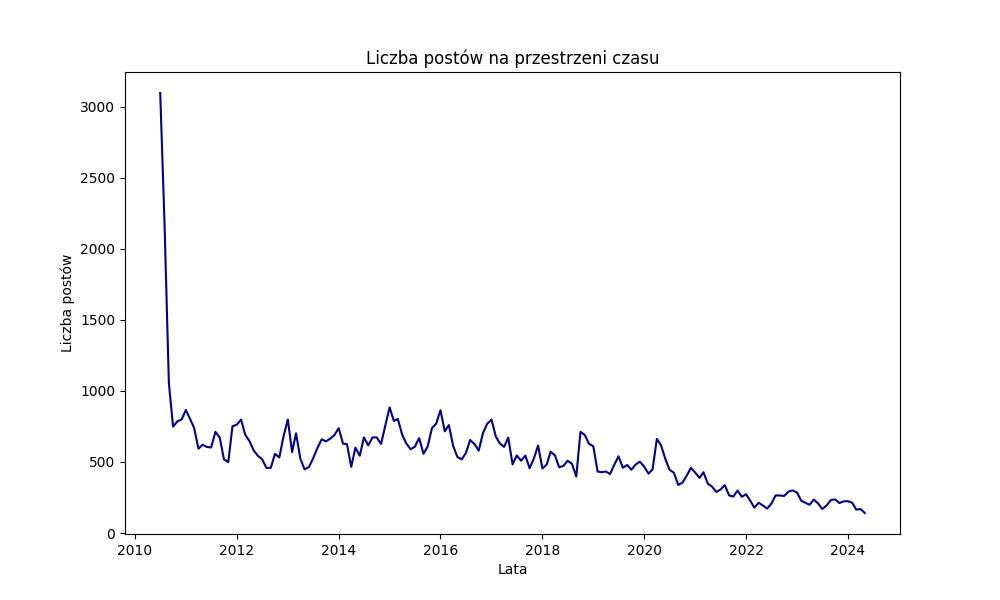

In [20]:
# Prezentacja wykresu
%matplot plt

### Wnioski: 
#### Na początku wykresu widoczna jest wartość odstająca: możliwe, że spowodowana wczytaniem skumulowanych wcześniej danych z innej bazy. Dane charakteryzują się sezonowością.

## B: czas na forum (od pojawienia się użytkownika do ostatniego posta/komentarza) 10 najdłużej aktywnych użytkowników

In [21]:
# Wybór kolumn
users_lifetime = posts_df.select('creation_date', 'post_id', 'account_id', 'user_name')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
# Grupowanie danych
users_lifetime = users_lifetime.groupBy('account_id', 'user_name').agg(
    min('creation_date').alias('min_creation_date'),
    max('creation_date').alias('max_creation_date')
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
# Obliczanie różnicy dat
users_lifetime = users_lifetime.withColumn('date_diff', col('max_creation_date').cast('long') - col('min_creation_date').cast('long'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
# Sortowanie
users_lifetime = users_lifetime.orderBy("date_diff", ascending=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
# Przekonwertowanie dat
users_lifetime = users_lifetime.withColumn("min_creation_date", from_unixtime(col("min_creation_date")))
users_lifetime = users_lifetime.withColumn("max_creation_date", from_unixtime(col("max_creation_date")))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
# Obliczenie lat aktywności
users_lifetime = users_lifetime.withColumn("date_diff_days", (col("date_diff") / 86400).cast("int"))
users_lifetime = users_lifetime.withColumn("active_years", round(col("date_diff_days") / 365.0, 1))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
# Podgląd danych
users_lifetime.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+-------------------+-------------------+---------+--------------+------------+
|account_id|           user_name|  min_creation_date|  max_creation_date|date_diff|date_diff_days|active_years|
+----------+--------------------+-------------------+-------------------+---------+--------------+------------+
|     48394|                 Joe|2010-07-09 19:33:51|2024-05-07 19:18:28|436405477|          5050|        13.8|
|      5025|                 Rob|2010-07-22 11:02:47|2024-04-08 08:54:25|432769898|          5008|        13.7|
|    343080|     Journeyman Geek|2010-08-08 03:43:12|2024-04-22 14:14:54|432556302|          5006|        13.7|
|     35726|           beausmith|2010-11-14 01:36:18|2024-05-21 17:44:06|426614868|          4937|        13.5|
|     70017|        Kate Gregory|2010-11-01 00:19:28|2024-04-19 19:37:02|424984654|          4918|        13.5|
|     54319|    No&#39;am Newman|2010-11-23 16:26:06|2024-04-21 07:41:57|423155751|          4897|      

In [28]:
from pyspark.sql.functions import when
bins = [(0, 2), (2, 4), (4, 6), (6, 8), (8, 10), (10, 12), (12, 14)]

users_lifetime = users_lifetime.withColumn(
    "years_range",
    when((col("active_years") >= 0) & (col("active_years") < 2), "0-2")
    .when((col("active_years") >= 2) & (col("active_years") < 4), "2-4")
    .when((col("active_years") >= 4) & (col("active_years") < 6), "4-6")
    .when((col("active_years") >= 6) & (col("active_years") < 8), "6-8")
    .when((col("active_years") >= 8) & (col("active_years") < 10), "8-10")
    .when((col("active_years") >= 10) & (col("active_years") < 12), "10-12")
    .when((col("active_years") >= 12) & (col("active_years") < 14), "12-14")
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
range_counts = users_lifetime.groupBy("years_range").count()

total_users = users_lifetime.count()
range_percentages = range_counts.withColumn("percentage", round((col("count") / total_users) * 100, 2))


range_percentages.orderBy(col('years_range').cast('int')).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----+----------+
|years_range|count|percentage|
+-----------+-----+----------+
|        4-6|  508|      1.86|
|        6-8|  301|       1.1|
|        0-2|25443|     93.32|
|      10-12|   63|      0.23|
|       8-10|  166|      0.61|
|        2-4|  743|      2.73|
|      12-14|   41|      0.15|
+-----------+-----+----------+

In [30]:
# Wybór top 10 użytkowników
top_10_active_users = users_lifetime.orderBy(col("active_years").desc()).limit(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
top_10_active_users.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+-------------------+-------------------+---------+--------------+------------+-----------+
|account_id|           user_name|  min_creation_date|  max_creation_date|date_diff|date_diff_days|active_years|years_range|
+----------+--------------------+-------------------+-------------------+---------+--------------+------------+-----------+
|     48394|                 Joe|2010-07-09 19:33:51|2024-05-07 19:18:28|436405477|          5050|        13.8|      12-14|
|      5025|                 Rob|2010-07-22 11:02:47|2024-04-08 08:54:25|432769898|          5008|        13.7|      12-14|
|    343080|     Journeyman Geek|2010-08-08 03:43:12|2024-04-22 14:14:54|432556302|          5006|        13.7|      12-14|
|     70017|        Kate Gregory|2010-11-01 00:19:28|2024-04-19 19:37:02|424984654|          4918|        13.5|      12-14|
|     35726|           beausmith|2010-11-14 01:36:18|2024-05-21 17:44:06|426614868|          4937|        13.5|      12-14|
|     54

In [32]:
# Przekonwertowanie do DF Pandas
top_10_active_users_pd = top_10_active_users.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
# Osie i wykres
plt.figure(figsize=(10, 13))
x = top_10_active_users_pd['user_name'].apply(str)
y = top_10_active_users_pd['active_years']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
plt.figure(figsize=(10, 8))
plt.rc('axes', axisbelow=True)
plt.grid(which='major', axis='y', zorder=-1.0)
plt.bar(x, y, color='darkblue')
plt.xlabel(u'Nazwa u\u017Cytkownika')
plt.ylabel("Lata")
plt.title("Najd\u0142u\u017Cej aktywni u\u017Cytkownicy")
plt.xticks(rotation=90)
plt.tight_layout()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

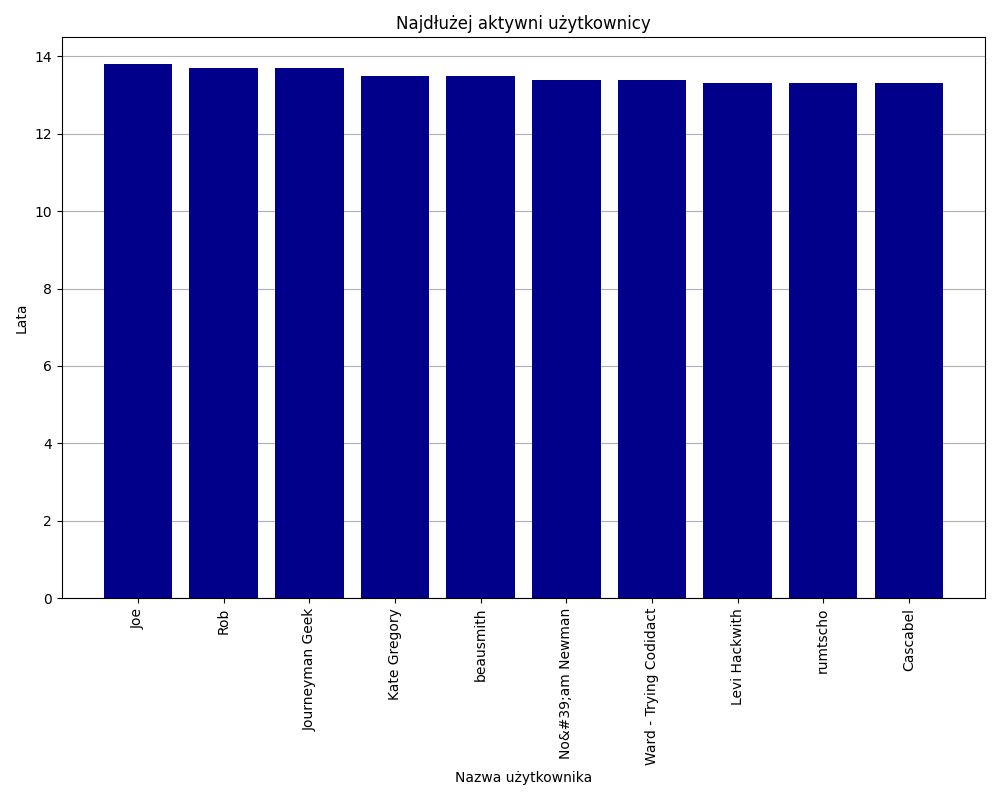

In [35]:
%matplot plt

## Wnioski:
### Najdłużej aktywni użytkownicy publikują posty od blisko początku istnienia forum Seasoned Advice

## Punkt C: porównanie najwyżej i najniżej ocenianych pytań (długość, tagi, liczba odpowiedzi)

In [36]:
# Wczytanie danych
questions_and_answers = spark.read.json('s3://raw-questions/questions.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
# Oczyszczenie kolumny body ze znaczników tekstowych HTML, usunięcie pustych linii i niepotrzebnych białych znaków
questions_and_answers = questions_and_answers.withColumn("body", regexp_replace(col("body"), "<[^>]*>", ""))
questions_and_answers = questions_and_answers.withColumn("body", regexp_replace(col("body"), "\\s+", " "))
questions_and_answers = questions_and_answers.withColumn("body", regexp_replace(col("body"), "^\\s+|\\s+$", ""))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
# Wyodrębnienie osobnych kolumn spod kolumny 'answers' do nowego dataframe
exploded_df = questions_and_answers.withColumn("answer", explode(col("answers")))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
answers = exploded_df.select(
    col("answer.answer_id").alias("answer_id"),
    col("answer.creation_date").alias("creation_date"),
    col("answer.is_accepted").alias("is_accepted"),
    col("answer.owner.user_id").alias("user_id"),
    col("answer.question_id").alias("question_id"),
    col("answer.score").alias("score")
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
# usunięcie orygnalnej zagnieżdżonej kolumny
questions = questions_and_answers.drop('answers')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
# rozpakowanie kolumny 'user_id' spod kolumny 'owner'
questions = questions.withColumn('user_id', col('owner.user_id'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
# usunięcie oryginalnej gnieżdżącej kolumny
questions = questions.drop('owner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
# Zapisanie danych w formacie Parquet na S3
questions.write.parquet("s3://questions-parquet/questions", mode='overwrite')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
answers.write.parquet("s3://answers-parquet/answers", mode='overwrite')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
# Wybór kolumn
min_max_scores_questions = questions.select("question_id", "tags", "title", "body", "score", "answer_count")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
min_max_scores_questions.orderBy(col("score").desc())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[question_id: bigint, tags: array<string>, title: string, body: string, score: bigint, answer_count: bigint]

In [47]:
# Szeregowanie danych
min_max_scores_questions = min_max_scores_questions.withColumn('score', col('score').cast('integer'))
min_max_scores_questions = min_max_scores_questions.orderBy(col("score").desc())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
min_max_scores_questions.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------------------+--------------------+--------------------+-----+------------+
|question_id|                tags|               title|                body|score|answer_count|
+-----------+--------------------+--------------------+--------------------+-----+------------+
|        567|[onions, knife-sk...|How can I chop on...|Onions are an exc...|  266|          21|
|        784|[language, cultur...|Translating cooki...|This post is an a...|  210|           7|
|       2574|[pasta, food-scie...|Why add salt to t...|What is the effec...|  178|          11|
|      84310|      [milk, kettle]|Why would boiling...|Or: is it safe fo...|  145|           7|
|      79674|           [chicken]|What is this colo...|I smoked a whole ...|  140|           2|
|       4708|[equipment, fish,...|Is it possible to...|I heard that ther...|  136|           7|
|      56418|[substitutions, f...|How can I tell th...|I received a ship...|  130|           7|
|        267|       [meat, steak]|How do

In [49]:
# Dodanie kolumny body_length na potrzeby pytania C
min_max_scores_questions = min_max_scores_questions.withColumn("body_length", length(col("body")))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
best_scores = min_max_scores_questions.limit(10).orderBy('score', ascending=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
worst_scores = min_max_scores_questions.orderBy('score', ascending=True).limit(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
worst_scores.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------------------+--------------------+--------------------+-----+------------+-----------+
|question_id|                tags|               title|                body|score|answer_count|body_length|
+-----------+--------------------+--------------------+--------------------+-----+------------+-----------+
|      19209|      [food-science]|Do you guys know ...|They are called c...|   -9|           1|         72|
|     113847|            [citrus]|How can even a sm...|Please see the se...|   -7|           1|        135|
|      68490|      [flavor, salt]|If salt loses its...|I have a shaker o...|   -7|           1|        438|
|      69137|      [oil, coconut]|How to eat coconu...|I'm having troubl...|   -7|           1|       1442|
|      79610|    [german-cuisine]|Why are german re...|French, Italian, ...|   -7|           1|        254|
|      32781|         [chocolate]|how to stretch wh...|I have several ba...|   -7|           1|        709|
|      92319|            [sh

### wykresy C_1: długość pytania vs. jego ocena

#### Najwyżej oceniane pytania

In [53]:
# Wybór kolumn
score_len = best_scores.select('score', 'body_length')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
# Przekonwertowanie DF do Pandas
score_len_pd = score_len.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
# Przygotowanie danych do wykresu

x = score_len_pd['score'].astype(str)
y = score_len_pd['body_length']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
plt.figure(figsize=(12, 8))
bars = plt.bar(x, y, color='darkblue')
for bar in bars:
    yval = bar.get_height()
    if yval != 94:  # Pomijanie wartości 94
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, int(yval), ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0.0, 222.05, '222')
Text(1.0, 501.05, '501')
Text(2.0, 384.05, '384')
Text(3.0, 89.05, '89')
Text(4.0, 103.05, '103')
Text(5.0, 744.05, '744')
Text(6.0, 66.05, '66')
Text(7.0, 24749.05, '24749')
Text(8.0, 208.05, '208')

In [57]:
# Konfiguracja osi
plt.xlabel('Ocena pytania')
plt.yscale('log')
ax = plt.gca()
ax.yaxis.set_major_locator(LogLocator(base=10, numticks=15))
ax.yaxis.set_major_formatter(ScalarFormatter())
plt.ylabel(u"Ilo\u015B\u0107 znak\u00F3w (log)")
plt.title(u"D\u0142ugo\u015B\u0107 najwy\u017Cej ocenionych pyta\u0144")
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Komentarz: Z powodu jednej wartości znacznie odstającej od pozostałych, na osi y została zastosowana skala logarytmiczna.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

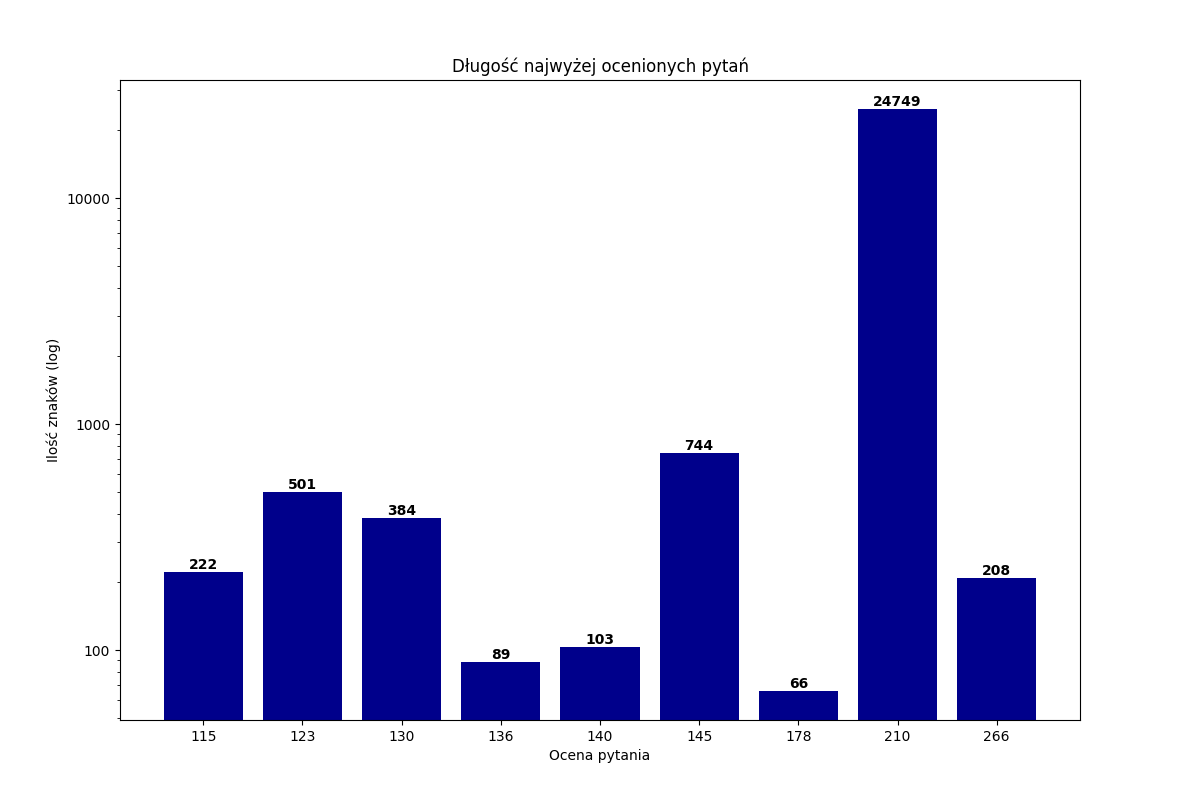

In [59]:
# Wykres
%matplot plt

## Wnioski:
### Większość z 10 najwyżej ocenianych pytań ma od 100 do 1000 znaków. Jedno pytanie jest niestandardowo długie i zostało bardzo wysoko ocenione, jednak ponieważ nie wystąpiło żadne inne pytanie podobnej długości , można je uznać za wyjątek.

#### Najniżej oceniane pytania

In [60]:
# Przekonwertowanie DF do Pandas
worst_scores_pd = worst_scores.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [61]:
worst_scores_pd.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   question_id              tags  ... answer_count body_length
0        19209    [food-science]  ...            1          72
1       113847          [citrus]  ...            1         135
2        68490    [flavor, salt]  ...            1         438
3        69137    [oil, coconut]  ...            1        1442
4        79610  [german-cuisine]  ...            1         254

[5 rows x 7 columns]

In [62]:
# Przygotowanie danych do wykresu

x = worst_scores_pd.index
y = worst_scores_pd['body_length']

labels = worst_scores_pd['score'].astype(str)
plt.figure(figsize=(14, 8))
plt.bar(x, y, color='darkblue')
x_labels = [f'{score}\n(ID: {qid})' for qid, score in zip(worst_scores_pd['question_id'], worst_scores_pd['score'])]

plt.xticks(ticks=x, labels=x_labels, rotation=45, ha='center')
plt.xlabel('Ocena pytania')
plt.ylabel("Ilo\u015B\u0107 znak\u00F3w")
plt.title('D\u0142ugo\u015B\u0107 najni\u017Cej ocenionych pyta\u0144')

bars = plt.bar(x, y, color='darkblue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, int(yval), ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0.0, 72.05, '72')
Text(1.0, 135.05, '135')
Text(2.0, 438.05, '438')
Text(3.0, 1442.05, '1442')
Text(4.0, 254.05, '254')
Text(5.0, 709.05, '709')
Text(6.0, 1725.05, '1725')
Text(7.0, 85.05, '85')
Text(8.0, 2123.05, '2123')
Text(9.0, 193.05, '193')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

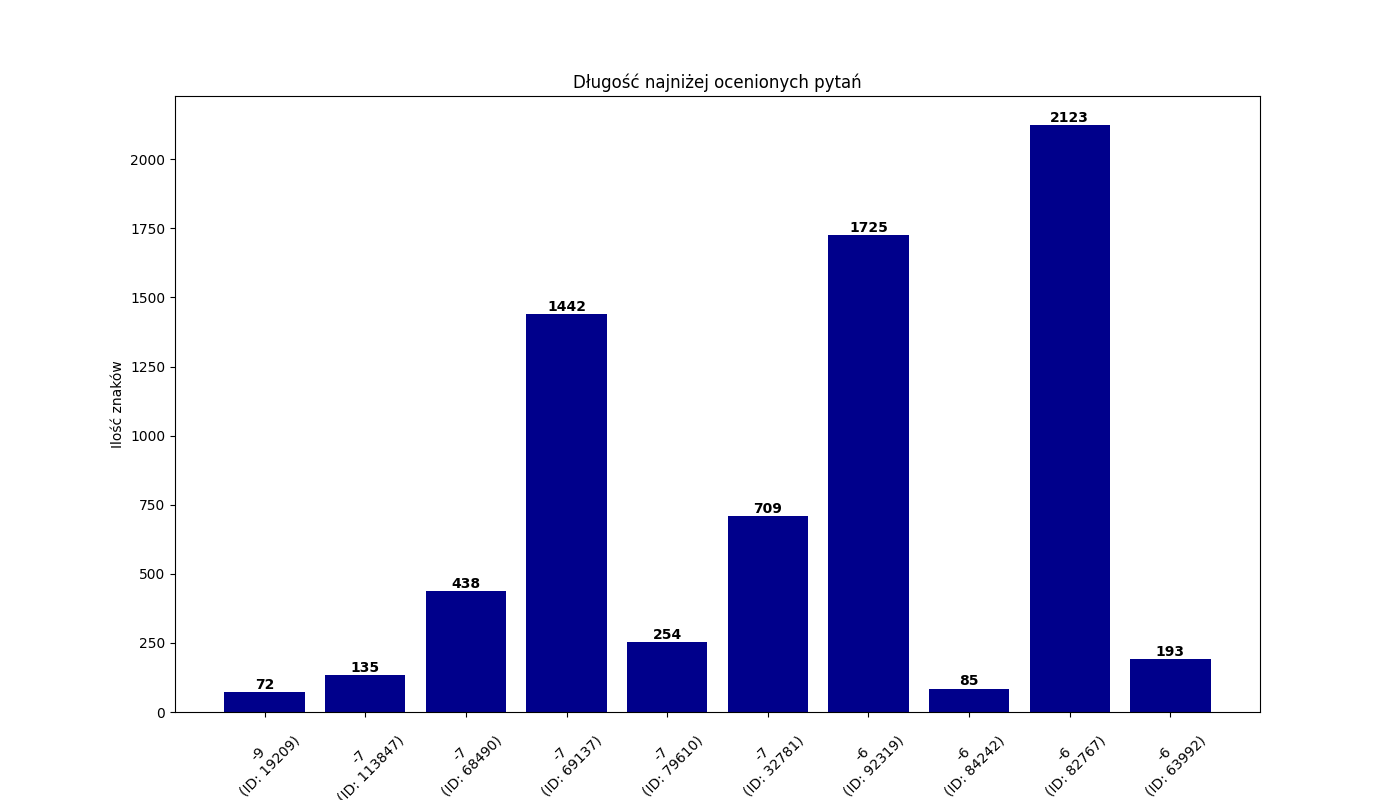

In [63]:
# Wykres
%matplot plt

### Wykresy C_2: Liczba odpowiedzi dla najwyżej i najniżej ocenionych pytań

#### Najwyżej oceniane pytania

In [64]:
# Wybór danych do Dataframe i przekonwertowanie ze Spark DF do Pandas

best_questions_and_its_answers = best_scores.select('score', 'answer_count')
best_questions_and_its_answers_pd = best_scores.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [65]:
# Przygotowanie danych do wykresu

#x = best_questions_and_its_answers_pd.index
y = best_questions_and_its_answers_pd.groupby('score').sum()['answer_count']
x = best_questions_and_its_answers_pd.groupby('score').sum().index

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Wniosek: dla najlepszych 10 ocen jest duża różnica w ocenach, dlatego na wykresie odległości pomiędzy słupkami są znacznie większe

In [66]:
# Wykres

plt.figure(figsize=(10, 6))
plt.bar(x, y, color='darkblue')
#plt.xticks(ticks=x, labels=labels)
plt.xlabel('Ocena pytania')
plt.ylabel("Liczba odpowiedzi")
plt.title(u"Liczba odpowiedzi dla najwy\u017Cej ocenionych pyta\u0144")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0.5, 1.0, 'Liczba odpowiedzi dla najwyżej ocenionych pytań')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

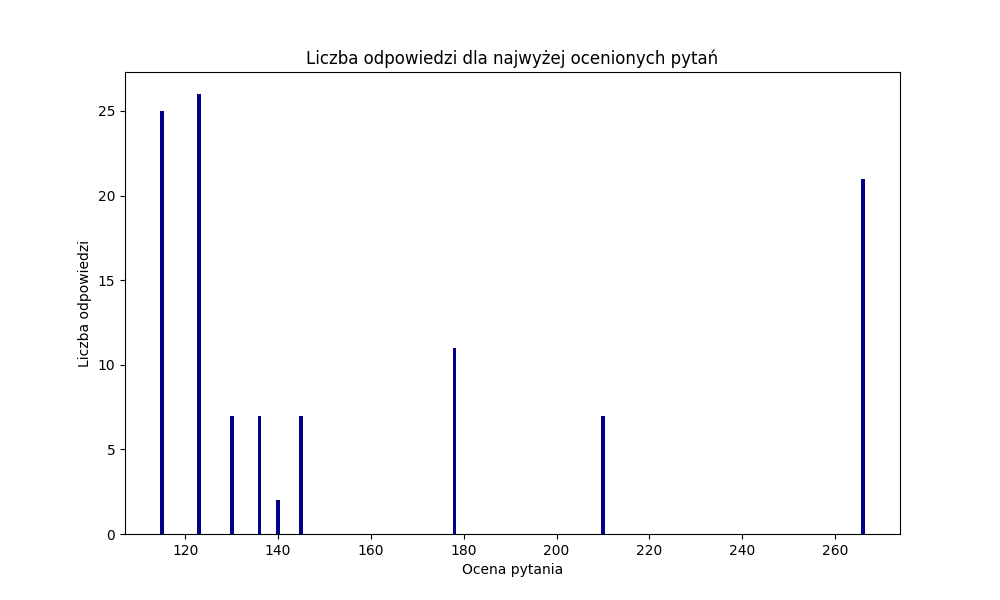

In [67]:
# Wykres
%matplot plt

#### Najniżej oceniane pytania

In [68]:
# Wybór danych do Dataframe i przekonwertowanie ze Spark DF do Pandas

worst_questions_and_its_answers = worst_scores.select('score', 'answer_count')
worst_questions_and_its_answers_pd = worst_questions_and_its_answers.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [69]:
# Przygotowanie danych do wykresu

#x = worst_questions_and_its_answers_pd.index 
y = worst_questions_and_its_answers_pd.groupby('score').sum()['answer_count']
x = worst_questions_and_its_answers_pd.groupby('score').sum().index

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [70]:
worst_questions_and_its_answers_pd.score = worst_questions_and_its_answers_pd.score.astype(int)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [71]:
worst_questions_and_its_answers_pd.groupby('score').sum()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       answer_count
score              
-9                1
-7                5
-6                4

In [72]:
# Wykres

plt.figure(figsize=(10, 6))
plt.bar(x, y, color='darkblue')
#plt.xticks(ticks=x, labels=labels)
plt.yticks(ticks=range(0, int(y.max()) + 1))
plt.xlabel('Ocena pytania')
plt.ylabel("Liczba odpowiedzi")
plt.title("Liczba odpowiedzi dla najni\u017Cej ocenionych pyta\u0144")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0.5, 1.0, 'Liczba odpowiedzi dla najniżej ocenionych pytań')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

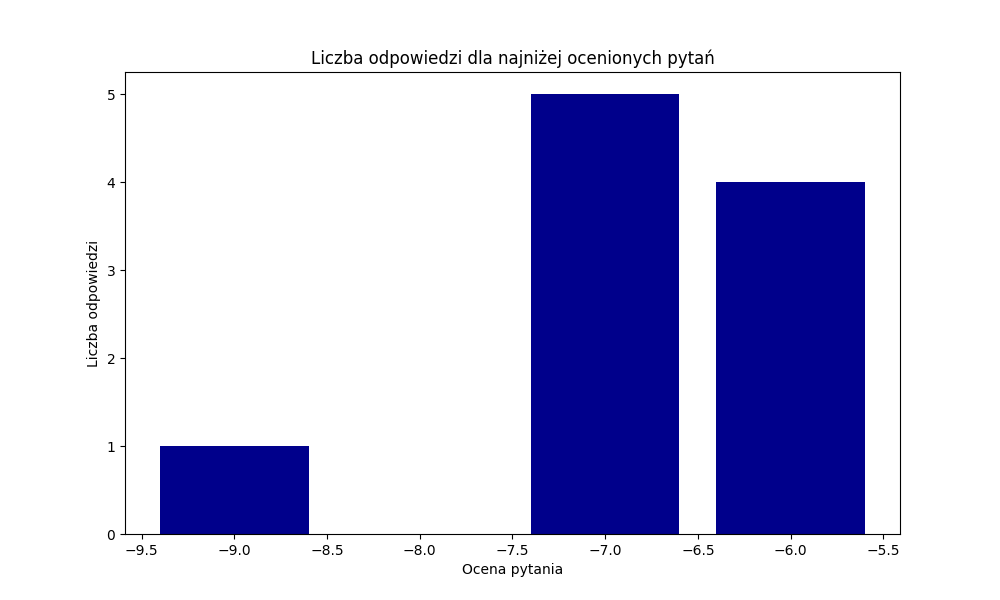

In [73]:
# Wykres
%matplot plt

### C_3: Tagi najwyżej i najniżej ocenianych pytań

#### Najwyżej oceniane pytania

In [74]:
best_tags = best_scores.select(explode('tags'))
tag_counts = best_tags.groupBy("col").count()
tag_counts.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+
|                col|count|
+-------------------+-----+
|        food-safety|    1|
|     storage-method|    1|
|   storage-lifetime|    1|
|             butter|    1|
|               eggs|    1|
|     scrambled-eggs|    1|
|               meat|    1|
|              steak|    1|
|      substitutions|    1|
|food-identification|    1|
|        cut-of-meat|    1|
|         butchering|    1|
|             rabbit|    1|
|          equipment|    1|
|               fish|    1|
|          sous-vide|    1|
|            chicken|    1|
|               milk|    1|
|             kettle|    1|
|              pasta|    1|
+-------------------+-----+
only showing top 20 rows

#### Najniżej oceniane pytania

In [75]:
worst_tags = worst_scores.select(explode('tags'))
tag_counts_worst = worst_tags.groupBy('col').count()
tag_counts_worst.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+-----+
|           col|count|
+--------------+-----+
|  food-science|    2|
|        citrus|    1|
|        flavor|    1|
|          salt|    1|
|           oil|    1|
|       coconut|    1|
|german-cuisine|    1|
|     chocolate|    1|
|        shrimp|    1|
|         lemon|    1|
|          lime|    1|
|   food-safety|    2|
|storage-method|    1|
|   temperature|    1|
|  refrigerator|    1|
|     microwave|    1|
+--------------+-----+

Pojedyncze tagi dla najgorszych i najlepszych pytań - wizualizacja prezentowałaby równe słupki

## D: procent przypadków kiedy najwyżej oceniana odpowiedź to niezaakceptowana odpowiedź

In [76]:
answers.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-------------+-----------+-------+-----------+-----+
|answer_id|creation_date|is_accepted|user_id|question_id|score|
+---------+-------------+-----------+-------+-----------+-----+
|     8946|   1289227283|      false|   2047|       8934|   -1|
|     8947|   1289229299|      false|   3237|       8934|    0|
|     8949|   1289243174|       true|   2882|       8934|   20|
|    42592|   1394216197|      false|  23667|       8934|    8|
|    57819|   1432764110|      false|  35811|       8934|   -1|
|    71765|   1469827911|      false|  48398|       8934|    1|
|   103073|   1572025419|      false|  26942|       8934|    2|
|   125745|   1699275462|      false| 106816|       8934|   -1|
|   128423|   1716925098|      false| 110442|       8934|    0|
|    65887|   1453804008|      false|  20183|      65886|    8|
|    65907|   1453836815|       true|  12565|      65886|    9|
|    87552|   1517851411|       true|   2001|      87548|    5|
|    87559|   1517867215|      false|  6

In [77]:
# Filtracja wierszy, gdzie is_answered to True (czyli pytanie zostało odpowiedziane)
answered_df = answers.filter(col("is_answered") == True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [78]:
# Znalezienie maksymalnej wartości oceny (score) dla każdego id_pytania
max_score_df = answers.groupBy("question_id").agg(max("score").alias("max_score"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [79]:
# Podgląd danych

## + wydrukowac tablice
max_score_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+---------+
|question_id|max_score|
+-----------+---------+
|       9458|       34|
|       9460|       12|
|       9461|        8|
|       9476|        3|
|       9477|        5|
|       9480|        2|
|       9482|        1|
|       9491|        4|
|       9492|        2|
|       9494|        2|
|       9499|       25|
|       9501|       12|
|       9503|       11|
|       9507|        1|
|       9509|        3|
|       9510|        1|
|       9511|       11|
|       9515|       17|
|       9522|       25|
|       9526|        6|
+-----------+---------+
only showing top 20 rows

In [80]:
# Dołączenie maksymalnej wartości oceny do odpowiedzi
answers_max_score_df = answers.join(max_score_df, ["question_id"], "inner")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [81]:
# Filtracja wierszy, gdzie czy_zaakceptowana to False i ocena jest równa maks_ocena
unaccepted_df = answers_max_score_df.filter((~col("is_accepted")) & (col("score") == col("max_score")))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [82]:
# Zliczenie wystąpień maks_ocena dla każdego id_pytania
max_scores_num_df = unaccepted_df.groupBy("question_id", "max_score").agg(count("score").alias("max_scores_num"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [83]:
# Dołączenie liczby wystąpień maks_ocena do oryginalnego DataFrame
unaccepted_with_max = unaccepted_df.join(max_scores_num_df, ["question_id", "max_score"], "left_outer")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [84]:
# Dodanie nowej kolumny, czy warunek jest spełniony dla danego wiersza
conditioned_data_df = unaccepted_with_max.withColumn("condition_met", expr("is_accepted = false AND score = max_score AND max_scores_num = 1"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [85]:
# Filtracja DataFrame, aby zawierał tylko wiersze, gdzie warunek jest spełniony
result_df = conditioned_data_df.filter(col("condition_met"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [86]:
# Obliczenie całkowitej liczby unikalnych odpowiedzi
total_unique_answers = answers.select("answer_id").distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [87]:
# Obliczenie liczby niezaakceptowanych najwyżej ocenionych odpowiedzi
non_accepted_answers = result_df.select("answer_id").distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [88]:
# Obliczenie procentu niezaakceptowanych najwyżej ocenionych odpowiedzi
percentage_non_accepted = (non_accepted_answers * 100) / total_unique_answers

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [89]:
print(f"Procent przypadków, w których najwyżej oceniona odpowiedź to niezaakceptowana odpowiedź: {percentage_non_accepted:.2f}%")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Procent przypadk?w, w kt?rych najwy?ej oceniona odpowied? to niezaakceptowana odpowied?: 21.39%

##  E: rozkład ocen odpowiedzi zaakceptowanych vs pozostałych (średnia, odchylenie, minimum, maksimum)

In [90]:
accepted_stats = answers.filter(answers["is_accepted"] == True) \
     .agg(avg("score").alias("mean_accepted"),
          stddev("score").alias("stddev_accepted"),
          min("score").alias("min_accepted"),
          max("score").alias("max_accepted")) \
     .collect()[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [91]:
not_accepted_stats = answers.filter(answers["is_accepted"] != True) \
     .agg(avg("score").alias("mean_not_accepted"),
          stddev("score").alias("stddev_not_accepted"),
          min("score").alias("min_not_accepted"),
          max("score").alias("max_not_accepted")) \
     .collect()[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [92]:
print("Rozkład ocen zaakceptowanych:")
print("Średnia:", accepted_stats["mean_accepted"])
print("Odchylenie standardowe:", accepted_stats["stddev_accepted"])
print("Minimum:", accepted_stats["min_accepted"])
print("Maksimum:", accepted_stats["max_accepted"])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Rozk?ad ocen zaakceptowanych:
?rednia: 8.029717682020802
Odchylenie standardowe: 9.924284698264712
Minimum: -6
Maksimum: 210

In [93]:
print("\nRozkład ocen niezaakceptowanych:")
print("Średnia:", not_accepted_stats["mean_not_accepted"])
print("Odchylenie standardowe:", not_accepted_stats["stddev_not_accepted"])
print("Minimum:", not_accepted_stats["min_not_accepted"])
print("Maksimum:", not_accepted_stats["max_not_accepted"])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


Rozk?ad ocen niezaakceptowanych:
?rednia: 2.9985682624982837
Odchylenie standardowe: 5.3348306868801245
Minimum: -14
Maksimum: 271

In [94]:
import numpy as np
accepted_scores = answers.filter(answers["is_accepted"] == True).select("score").toPandas()["score"]
not_accepted_scores = answers.filter(answers["is_accepted"] != True).select("score").toPandas()["score"]
accepted_scores = np.clip(accepted_scores, -6, 210)
not_accepted_scores = np.clip(not_accepted_scores, -6, 210)

accepted_scores_below_30 = accepted_scores[accepted_scores <= 50]
not_accepted_scores_below_30 = not_accepted_scores[not_accepted_scores <= 50]

plt.figure(figsize=(12, 6))

# Histogram dla zaakceptowanych ocen (do 50)
plt.subplot(1, 2, 1)
plt.hist(accepted_scores_below_50, bins=30, edgecolor='black', color='green', alpha=0.7)
plt.axvline(np.mean(accepted_scores_below_50), color='k', linestyle='dashed', linewidth=1)
plt.text(np.mean(accepted_scores_below_50)*1.1, plt.ylim()[1]*0.9, f'Mean: {accepted_stats["mean_accepted"]:.2f}', color='black')
plt.title('Oceny odpowiedzi zaakceptowanych (do 50)')
plt.xlabel('Ocena')
plt.ylabel(u'Liczba wystąpie\u0144')
plt.grid(True)

# Histogram dla niezaakceptowanych ocen (do 50)
plt.subplot(1, 2, 2)
plt.hist(not_accepted_scores_below_50, bins=30, edgecolor='black', color='red', alpha=0.7)
plt.axvline(np.mean(not_accepted_scores_below_50), color='k', linestyle='dashed', linewidth=1)
plt.text(np.mean(not_accepted_scores_below_50)*1.1, plt.ylim()[1]*0.9, f'Mean: {not_accepted_stats["mean_not_accepted"]:.2f}')
plt.title('Oceny odpowiedzi niezaakceptowanych (do 50)')
plt.xlabel('Ocena')
plt.ylabel(u'Liczba wystąpie\u0144')
plt.grid(True)

plt.tight_layout()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'accepted_scores_below_50' is not defined
Traceback (most recent call last):
NameError: name 'accepted_scores_below_50' is not defined



+ histogram 

## F: top 3 tagi które wygenerowały najwięcej wyświetleń

In [95]:
# Wybór potrzebnych kolumn z dataframe questions
tags_df = questions.select('tags', 'view_count').orderBy('view_count')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [96]:
# Wyciągnięcie tagów z listy
tags_exploded = tags_df.select(explode('tags').alias('tag'), 'view_count')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [97]:
# Sprawdzenie schematu i typu danych
tags_exploded.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- tag: string (nullable = true)
 |-- view_count: long (nullable = true)

In [98]:
# Zmiana formatu danych w kolumnie view_count na int
tags_exploded = tags_exploded.withColumn("view_count", col("view_count").cast("int"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [99]:
# Zgrupowanie danych po tagach i zsumowanie liczby wyświetleń
tag_view_counts = tags_exploded.groupBy('tag').agg(sum(('view_count')).alias('view_count')).orderBy("view_count", ascending=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [100]:
# Podgląd danych
tag_view_counts.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+----------+
|             tag|view_count|
+----------------+----------+
|     food-safety|  58357991|
|          baking|  35617122|
|   substitutions|  32589352|
|         chicken|  17472495|
|           bread|  16093433|
|            meat|  13747495|
|            eggs|  13528525|
|       equipment|  13477325|
|  storage-method|  13180828|
|storage-lifetime|  12888530|
|     temperature|  11347282|
|            oven|  10288086|
|           pasta|   9311750|
|    refrigerator|   9171406|
|           sauce|   8758006|
|            rice|   8227807|
|            beef|   8052813|
|          coffee|   7842555|
|        freezing|   7695303|
|           dough|   7437758|
+----------------+----------+
only showing top 20 rows

In [101]:
# Wybór top 3 tagów z najwyższą liczbą wyświetleń
top_3_tags = tag_view_counts.limit(3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [102]:
# Wynik:
top_3_tags.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+----------+
|          tag|view_count|
+-------------+----------+
|  food-safety|  58357991|
|       baking|  35617122|
|substitutions|  32589352|
+-------------+----------+

## G: liczba postów w czasie dla każdego z top N tagów (lineplot/barplot) 

In [103]:
# Wybór potrzebnych kolumn
tags_in_time = questions.select('creation_date', 'tags')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [104]:
# Podgląd danych
tags_in_time.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+--------------------+
|creation_date|                tags|
+-------------+--------------------+
|   1716917390|[beef, dehydratin...|
|   1289183621|[pasta, salt, boi...|
|   1453803359|[food-safety, foo...|
|   1517847516|[food-safety, fer...|
|   1282666001| [potatoes, blender]|
|   1409677085|  [boiling, canning]|
|   1593125308|[food-safety, cut...|
|   1568149736|[fermentation, ga...|
|   1476451146|[beans, chili-pep...|
|   1372112336|[maintenance, alu...|
|   1716807844|[food-preservatio...|
|   1716742872|[food-safety, coo...|
|   1713715990|          [extracts]|
|   1716764946|[chicken, vegetab...|
|   1551551439|[baking, bread, y...|
|   1716679688|  [flavor, tomatoes]|
|   1716689366|[butter, fat, nut...|
|   1560891180|[mixing, meringue...|
|   1297706431|        [mayonnaise]|
|   1716248048|[deep-frying, chi...|
+-------------+--------------------+
only showing top 20 rows

In [105]:
# Przekonwertowanie daty z formatu EPOCH na UTC
tags_in_time = tags_in_time.withColumn('creation_date', from_unixtime(col('creation_date')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [106]:
# Zmiana formatu z YYYY-MM-DD na YYYY-MM
tags_in_time = tags_in_time.withColumn("creation_date", date_format("creation_date", "yyyy-MM"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [107]:
# Podgląd danych
tags_in_time.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+--------------------+
|creation_date|                tags|
+-------------+--------------------+
|      2024-05|[beef, dehydratin...|
|      2010-11|[pasta, salt, boi...|
|      2016-01|[food-safety, foo...|
|      2018-02|[food-safety, fer...|
|      2010-08| [potatoes, blender]|
|      2014-09|  [boiling, canning]|
|      2020-06|[food-safety, cut...|
|      2019-09|[fermentation, ga...|
|      2016-10|[beans, chili-pep...|
|      2013-06|[maintenance, alu...|
|      2024-05|[food-preservatio...|
|      2024-05|[food-safety, coo...|
|      2024-04|          [extracts]|
|      2024-05|[chicken, vegetab...|
|      2019-03|[baking, bread, y...|
|      2024-05|  [flavor, tomatoes]|
|      2024-05|[butter, fat, nut...|
|      2019-06|[mixing, meringue...|
|      2011-02|        [mayonnaise]|
|      2024-05|[deep-frying, chi...|
+-------------+--------------------+
only showing top 20 rows

In [108]:
# Wyciągnięcie tagów z listy w kolumnie tags
tags_in_time = tags_in_time.select('creation_date', explode('tags').alias('tag'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [109]:
# Filtrowanie danych po tagach z dataframe'u top_3_tags 
unique_tags = [row["tag"] for row in top_3_tags.select("tag").collect()]
tags_in_time = tags_in_time.filter(col("tag").isin(unique_tags))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [110]:
# Grupowanie danych i zliczenie występowania taga w danym miesiącu w kolumnie post_count
tags_in_time = tags_in_time.groupBy("creation_date", "tag").agg(count("tag").alias("post_count"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [111]:
# Podgląd danych
tags_in_time.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+-------------+----------+
|creation_date|          tag|post_count|
+-------------+-------------+----------+
|      2011-09|substitutions|        15|
|      2017-03|  food-safety|        14|
|      2022-09|       baking|         7|
|      2013-10|       baking|        19|
|      2016-04|  food-safety|        18|
|      2018-08|       baking|        13|
|      2022-07|  food-safety|         7|
|      2019-05|       baking|        12|
|      2015-12|  food-safety|        14|
|      2016-11|substitutions|        12|
|      2018-04|  food-safety|        14|
|      2019-09|       baking|        14|
|      2016-08|substitutions|        11|
|      2011-07|  food-safety|        11|
|      2022-08|  food-safety|        14|
|      2022-04|  food-safety|         7|
|      2023-04|       baking|         6|
|      2020-11|  food-safety|         9|
|      2020-03|substitutions|        11|
|      2014-08|  food-safety|        15|
+-------------+-------------+----------+
only showing top

In [112]:
# Zamiana dataframe na Pandas
tags_in_time_pd = tags_in_time.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [113]:
# Przekształcenie dataframe za pomocą funkcji pivot
pivoted_tags_in_time_pd = tags_in_time_pd.pivot(index="creation_date", columns="tag", values="post_count").fillna(0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [114]:
pivoted_tags_in_time_pd = pivoted_tags_in_time_pd.sort_index()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [115]:
# Ustawienie rozmiaru wykresu
plt.figure(figsize=(14, 8))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<Figure size 1400x800 with 0 Axes>

In [116]:
# Tworzenie wykresu
pivoted_tags_in_time_pd.plot(kind='line', marker='')
plt.title(u'Liczba post\u00F3w dla ka\u017Cdego taga w danym miesi\u0105cu')
plt.xlabel('Data')
plt.ylabel('Liczba post\u00F3w')
plt.xticks(rotation=45)
plt.legend(title='Tagi')
plt.grid(True)
plt.tight_layout()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

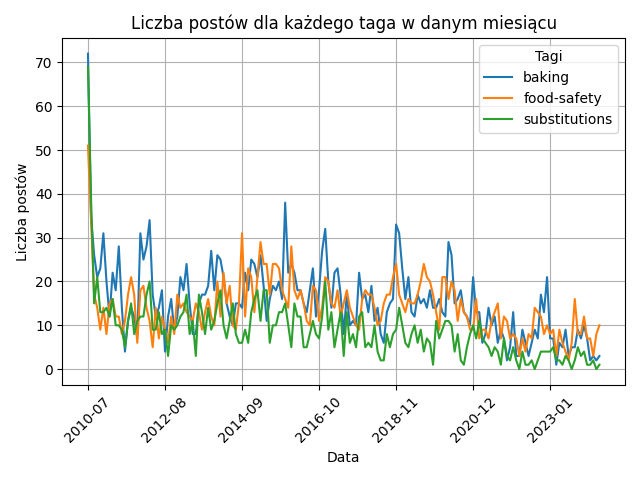

In [117]:
# Wykres
%matplot plt

Wysokie wartości na poczatku wykresu moga swiadczyc o skumulowanych danych z poprzednich okresow, bądż mogą być anomalią. Dane mają lekki charakter sezonowy: posty z konkretnych tagów pojawiały się w zbliżonych odstępach czasowych, co moze być związane np. z okresem świątecznym.

## H. Najczęściej pojawiające się słowa w tytułach (z pominięciem stopwords)

In [118]:
titles = questions.select('title').distinct()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [119]:
from pyspark.sql.functions import col, regexp_extract

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [120]:
# Szukanie, których znaczników należy się pozbyć z kolumny title
patterns = [
    "From:.+\n",
    "Reply-To:.+\n",
    "Nntp.+ ",
    "Subject:+ ",
    "Lines:.+\n",
    "Organization:+ ",
    "\S+@\S+\s",
    "Re:+ ",
    "\n|\t",
    "\S*\d+\S*",
    "\s\W*\w\W*\s",
    "\W+"
]

for pattern in patterns:
    titles = titles.withColumn("matched", regexp_extract(col("title"), pattern, 0))
    if titles.filter(col("matched") != "").count() > 0:
        print(f"Pattern found: {pattern}")
    else:
        print(f"Pattern not found: {pattern}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Pattern not found: From:.+

Pattern not found: Reply-To:.+

Pattern not found: Nntp.+ 
Pattern not found: Subject:+ 
Pattern not found: Lines:.+

Pattern not found: Organization:+ 
Pattern not found: \S+@\S+\s
Pattern not found: Re:+ 
Pattern not found: 
|	
Pattern found: \S*\d+\S*
Pattern found: \s\W*\w\W*\s
Pattern found: \W+

In [121]:
# Usunięcie pomocniczej kolumny
titles = titles.drop('matched')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [122]:
# Usunięcie zbędnych znaczników
titles = titles.withColumn('title', regexp_replace('title', "\S*\d+\S*", ' '))\
                 .withColumn('title', regexp_replace('title', "\s\W*\w\W*\s", ' '))\
                 .withColumn('title', regexp_replace('title', "\W+", ' '))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [123]:
from pyspark.sql.functions import lower
titles = titles.withColumn('title', lower('title'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [124]:
from pyspark.ml.feature import RegexTokenizer

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [125]:
tokenizer = RegexTokenizer(inputCol="title", outputCol="words", pattern="\\W")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [126]:
titles = tokenizer.transform(titles)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [127]:
from pyspark.ml.feature import StopWordsRemover

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [128]:
sw_remover = StopWordsRemover(inputCol='words', outputCol='words_cleaned')
sw_remover.getStopWords()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

In [129]:
titles = sw_remover.transform(titles)
titles.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+
|               title|               words|       words_cleaned|
+--------------------+--------------------+--------------------+
|has my cider ferm...|[has, my, cider, ...|  [cider, fermented]|
|how to identify f...|[how, to, identif...|[identify, fresh,...|
|first onion or fi...|[first, onion, or...|[first, onion, fi...|
|chocolate choux p...|[chocolate, choux...|[chocolate, choux...|
|can substitute bl...|[can, substitute,...|[substitute, blac...|
+--------------------+--------------------+--------------------+
only showing top 5 rows

In [130]:
import nltk
stemmer = nltk.PorterStemmer()
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [131]:
def stem_words(words):
     return [stemmer.stem(w) for w in words]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [132]:
stem_words_udf = udf(f=stem_words, returnType=ArrayType(StringType()))
titles = titles.withColumn('words_stemmed', stem_words_udf(titles.words_cleaned))
titles.printSchema()
titles.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- title: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words_cleaned: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)

+--------------------+--------------------+--------------------+--------------------+
|               title|               words|       words_cleaned|       words_stemmed|
+--------------------+--------------------+--------------------+--------------------+
|has my cider ferm...|[has, my, cider, ...|  [cider, fermented]|    [cider, ferment]|
|how to identify f...|[how, to, identif...|[identify, fresh,...|[identifi, fresh,...|
|first onion or fi...|[first, onion, or...|[first, onion, fi...|[first, onion, fi...|
|chocolate choux p...|[chocolate, choux...|[chocolate, choux...|[chocol, choux, p...|
|can substitute bl...|[can, substitute,...|[substitute, blac...|[substitut, black...|
|

In [133]:
from pyspark.ml.feature import CountVectorizer, IDF

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [134]:
count_vectorizer = CountVectorizer(inputCol="words_stemmed", outputCol="term_freq", minDF=2.0, maxDF=0.5)

count_vectorizer_model = count_vectorizer.fit(titles)
titles = count_vectorizer_model.transform(titles)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [135]:
count_vectorizer_model.vocabulary

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['cook', 'make', 'use', 'quot', 'bake', 'bread', 'chicken', 'recip', 'food', 'safe', 'substitut', 'egg', 'differ', 'oven', 'sauc', 'pan', 'oil', 'meat', 'water', 'without', 'cake', 'dough', 'fri', 'long', 'milk', 'cream', 'dri', 'get', 'way', 'temperatur', 'store', 'flour', 'sugar', 'butter', 'rice', 'chocol', 'tast', 'time', 'keep', 'chees', 'beef', 'salt', 'roast', 'boil', 'potato', 'vs', 'white', 'best', 'frozen', 'like', 'good', 'fresh', 'eat', 'need', 'much', 'veget', 'flavor', 'cooki', 'powder', 'pot', 'pizza', 'freez', 'bean', 'heat', 'add', 'tomato', 'made', 'hot', 'soup', 'microwav', 'refriger', 'ingredi', 'ad', 'coffe', 'ice', 'pasta', 'raw', 'fish', 'iron', 'cooker', 'mix', 'tea', 'brown', 'prepar', 'fridg', 'prevent', 'dish', 'onion', 'fruit', 'pork', 'yeast', 'homemad', 'cut', 'instead', 'turn', 'season', 'pie', 'grill', 'fat', 'home', 'one', 'sourdough', 'stick', 'garlic', 'remov', 'cast', 'steak', 'clean', 'pepper', 'black', 'top', 'whole', 'sweet', 'possibl', 'juic', 't

In [136]:
len(count_vectorizer_model.vocabulary)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

4551

In [137]:
titles.select('term_freq').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|           term_freq|
+--------------------+
|(4551,[136,729],[...|
|(4551,[51,89,393,...|
|(4551,[17,87,278,...|
|(4551,[35,204,135...|
|(4551,[10,1056],[...|
+--------------------+
only showing top 5 rows

In [138]:
idf = IDF(inputCol="term_freq", outputCol="tfidf")
idf_model = idf.fit(titles)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [139]:
titles = idf_model.transform(titles)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [140]:
titles.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               title|               words|       words_cleaned|       words_stemmed|           term_freq|               tfidf|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|has my cider ferm...|[has, my, cider, ...|  [cider, fermented]|    [cider, ferment]|(4551,[136,729],[...|(4551,[136,729],[...|
|how to identify f...|[how, to, identif...|[identify, fresh,...|[identifi, fresh,...|(4551,[51,89,393,...|(4551,[51,89,393,...|
|first onion or fi...|[first, onion, or...|[first, onion, fi...|[first, onion, fi...|(4551,[17,87,278,...|(4551,[17,87,278,...|
|chocolate choux p...|[chocolate, choux...|[chocolate, choux...|[chocol, choux, p...|(4551,[35,204,135...|(4551,[35,204,135...|
|can substitute bl...|[can, substitute,...|[substitute, blac...|[substitut, black...|(4551,[10,1056],[..

In [141]:
words_df = titles.select(explode("words_stemmed").alias("word"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [142]:
word_frequencies = words_df.groupBy("word").count().orderBy("count", ascending=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [143]:
word_frequencies.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----+
|     word|count|
+---------+-----+
|     cook| 2552|
|     make| 2471|
|      use| 2250|
|     quot| 1741|
|     bake| 1154|
|    bread| 1089|
|  chicken|  979|
|    recip|  891|
|     food|  866|
|     safe|  853|
|substitut|  840|
|      egg|  836|
|   differ|  828|
|     oven|  802|
|     sauc|  784|
|      pan|  783|
|      oil|  778|
|     meat|  773|
|    water|  762|
|  without|  739|
+---------+-----+
only showing top 20 rows

Wniosek: najczęściej powtarzane słowa to podstawowe rzeczowniki i czasowniki związane z gotowaniem

+ wordcloud (package wordcloud: https://medium.com/@m3redithw/wordclouds-with-python-c287887acc8b)

In [144]:
word_selection = word_frequencies.limit(100)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [145]:
word_selection_pd = word_selection.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [146]:
word_count_dict = dict(zip(word_selection_pd['word'], word_selection_pd['count']))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

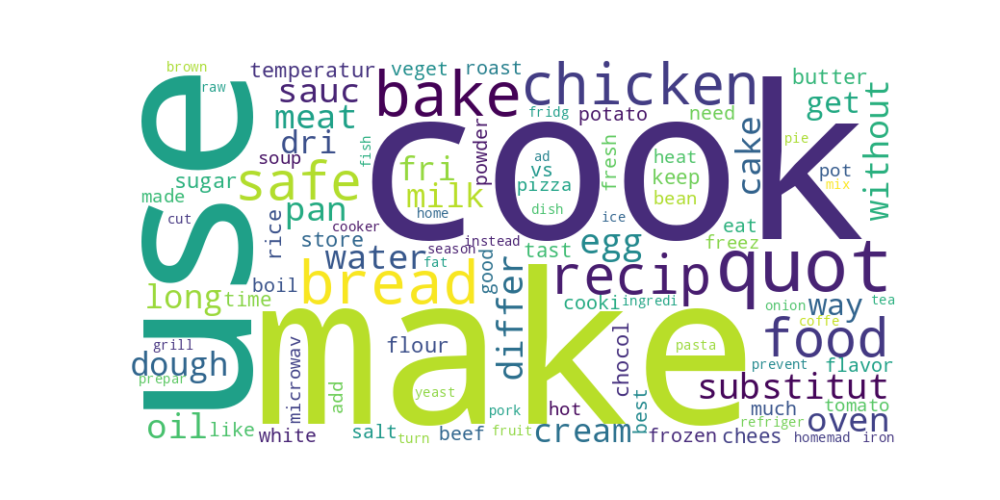

In [147]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_count_dict)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
%matplot plt

## I: procent użytkowników którzy nigdy nic nie zapostowali

In [148]:
# Wczytanie danych z S3
users = spark.read.json('s3://raw-users/users.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [149]:
# Sprawdzenie schematu i typu danych
users.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- account_id: long (nullable = true)
 |-- answer_count: long (nullable = true)
 |-- question_count: long (nullable = true)

In [150]:
# Zamiana typu danych w kolumnie answer_count i question_count na 'int'
users = users.withColumn("answer_count", col("answer_count").cast("int"))
users = users.withColumn("question_count", col("question_count").cast("int"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [151]:
# Dodanie kolumny zliczającej sumę postów
users = users.withColumn("posts_total", col("answer_count") + col("question_count"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [152]:
# Podgląd danych
users.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------------+--------------+-----------+
|account_id|answer_count|question_count|posts_total|
+----------+------------+--------------+-----------+
|    266065|        2174|           127|       2301|
|     48394|        1507|            21|       1528|
|    175757|        1234|            10|       1244|
|   2459758|        1467|             5|       1472|
|   1148237|        1253|            17|       1270|
|    542323|         873|            81|        954|
|   4948536|         691|            11|        702|
|   3302527|         793|           141|        934|
|     41301|         762|            65|        827|
|     17239|         414|            27|        441|
|    505193|         527|            56|        583|
|   2618090|         733|            38|        771|
|    508233|         591|            21|        612|
|     36994|         309|            17|        326|
|   2195448|         383|            13|        396|
|    505186|         386|            40|      

In [153]:
# Zliczenie użytkowników, którzy nigdy nic nie zapostowali
inactive_users = users.filter(col('posts_total')==0).count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [154]:
# Zliczenie wszystkich użytkowników
all_users = users.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [155]:
# Obliczenie procentu nieaktywnych użytkowników
inactive_users_percentage = (inactive_users * 100) / all_users

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [156]:
# Wyświetlenie wyniku
print(f"Procent nieaktywnych u\u017Cytkownik\u00F3w to: {inactive_users_percentage:.2f}%")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Procent nieaktywnych użytkowników to: 65.50%

## J. Średni czas od pojawienia się pytania do pojawienia się zaakceptowanej odpowiedzi

In [157]:
questions_and_answers.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- accepted_answer_id: long (nullable = true)
 |-- answer_count: long (nullable = true)
 |-- answers: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- answer_id: long (nullable = true)
 |    |    |-- creation_date: long (nullable = true)
 |    |    |-- is_accepted: boolean (nullable = true)
 |    |    |-- owner: struct (nullable = true)
 |    |    |    |-- user_id: long (nullable = true)
 |    |    |-- question_id: long (nullable = true)
 |    |    |-- score: long (nullable = true)
 |-- body: string (nullable = true)
 |-- creation_date: long (nullable = true)
 |-- is_answered: boolean (nullable = true)
 |-- owner: struct (nullable = true)
 |    |-- user_id: long (nullable = true)
 |-- question_id: long (nullable = true)
 |-- score: long (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title: string (nullable = true)
 |-- view_count: long (nullable = true)

In [158]:
avg_response_time = questions_and_answers.filter(col('is_answered') == True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [159]:
avg_response_time = avg_response_time.withColumn("answer", explode("answers"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [160]:
avg_response_time.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+------------+--------------------+--------------------+-------------+-----------+-------+-----------+-----+--------------------+--------------------+----------+--------------------+
|accepted_answer_id|answer_count|             answers|                body|creation_date|is_answered|  owner|question_id|score|                tags|               title|view_count|              answer|
+------------------+------------+--------------------+--------------------+-------------+-----------+-------+-----------+-----+--------------------+--------------------+----------+--------------------+
|              8949|           9|[{8946, 128922728...|Most chefs recomm...|   1289183621|       true|  {141}|       8934|   19|[pasta, salt, boi...|When cooking past...|     23213|{8946, 1289227283...|
|              8949|           9|[{8946, 128922728...|Most chefs recomm...|   1289183621|       true|  {141}|       8934|   19|[pasta, salt, boi...|When cooking past...|     23213|{8947, 12892

In [161]:
avg_response_time = avg_response_time.select(
    col("question_id"),
    col("creation_date").alias("question_creation_date"),
    col("is_answered"),
    col("answer.answer_id").alias("answer_id"),
    col("answer.is_accepted").alias("is_accepted"),
    col("answer.creation_date").alias("answer_creation_date")
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [162]:
avg_response_time.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------------------+-----------+---------+-----------+--------------------+
|question_id|question_creation_date|is_answered|answer_id|is_accepted|answer_creation_date|
+-----------+----------------------+-----------+---------+-----------+--------------------+
|       8934|            1289183621|       true|     8946|      false|          1289227283|
|       8934|            1289183621|       true|     8947|      false|          1289229299|
|       8934|            1289183621|       true|     8949|       true|          1289243174|
|       8934|            1289183621|       true|    42592|      false|          1394216197|
|       8934|            1289183621|       true|    57819|      false|          1432764110|
|       8934|            1289183621|       true|    71765|      false|          1469827911|
|       8934|            1289183621|       true|   103073|      false|          1572025419|
|       8934|            1289183621|       true|   125745|      false|          

In [163]:
avg_response_time = avg_response_time.filter(col('is_accepted')=='true')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [164]:
avg_response_time = avg_response_time.withColumn("response_time", col("answer_creation_date") - col("question_creation_date"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [165]:
avg_response_time.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------------------+-----------+---------+-----------+--------------------+-------------+
|question_id|question_creation_date|is_answered|answer_id|is_accepted|answer_creation_date|response_time|
+-----------+----------------------+-----------+---------+-----------+--------------------+-------------+
|       8934|            1289183621|       true|     8949|       true|          1289243174|        59553|
|      65886|            1453803359|       true|    65907|       true|          1453836815|        33456|
|      87548|            1517847516|       true|    87552|       true|          1517851411|         3895|
|       5882|            1282666001|       true|     5887|       true|          1282670233|         4232|
|      74737|            1476451146|       true|    74748|       true|          1476470983|        19837|
|     128181|            1713715990|       true|   128185|       true|          1713726198|        10208|
|      96658|            1551551439|       tru

In [166]:
avg_response_time = avg_response_time.agg(avg("response_time").alias("avg_response_time_EPOCH"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [167]:
avg_response_time.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------+
|avg_response_time_EPOCH|
+-----------------------+
|     1294970.6020059434|
+-----------------------+

In [168]:
avg_response_time = avg_response_time.withColumn('avg_response_time_days', round(col('avg_response_time_EPOCH')/86400))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [169]:
avg_response_time.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------+----------------------+
|avg_response_time_EPOCH|avg_response_time_days|
+-----------------------+----------------------+
|     1294970.6020059434|                  15.0|
+-----------------------+----------------------+

Średni czas oczekiwania na zaakceptowaną odpowiedź to 15 dni